# Minder Check-in Multiclass Sentiment Classification and User Response Visualisation
Copyright 2021-2022, Maitreyee Wairagkar   
Last updated: 23/04/2022

In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd
import numpy as np
import collections
import math

### 1. Multinomial Naive Bayes with novel depedent features for multiclass sentiment classification

In [2]:
def train_mnw_naive_bayes(D,cl,C):
    # Multiclass binarised multinomial naive bayes classifier training 
    # Inputs - 
    # D: list of all training documents (training set)
    # cl: list of class labels corresponding to documents in D 
    # C: list of all classes (unique class labels)
    # Outputs - 
    # logprior: dictionary of log P(c) 
    # loglikelihood: dictionary of log P(w｜c) 
    # V: vocabulary in all dicuments D
    
    # Preprocess data
    D = preprocess_data(D)
    
    # Extract novel dependent features
    D = extract_features(D)
    
    # Tokenisation - Get vocabulary V in all documents D (all unique words in D)
    V = list(set(' '.join(D).split())) 
    # TODO: add OOV to V
    
    # declare loglikelihood as a nested dictionary containing P(w｜c)
    loglikelihood = {}
    
    # Calculate priors for each class. Here we assume uniform priors since we don't know the actual number
    # of documents per class, which change over time with more data and is highly user dependent
    logprior = {}
    for c in C:
        logprior[c]= math.log(1/len(C) ) # Uniform prior
        
        # Tokanisation - Get all words (features) in all documents belonging to class c and their frequencies
        all_words_docs_c = ' '.join([D[i] for i in range(len(D)) if cl[i]==c]).split()  
        unique_words_docs_c = list(set(all_words_docs_c))
        freq = dict(collections.Counter(all_words_docs_c))
            
        # Calculate likelihood of each word in the vocabulary given class c using Laplace (add 1) smoothing 
        loglikelihood[c] = {}
        for word in V:
            if word in unique_words_docs_c:
                
                # binarised multinomial Naive Bayes
                weight = 1
                if freq[word] > 3:
                    weight = 2
                loglikelihood[c][word] = math.log( (weight +1)/ (len(unique_words_docs_c) + len(V)) )

            else: # TODO: deal with OOV here
                loglikelihood[c][word] = math.log( (0+1)/ (len(unique_words_docs_c) + len(V)) )
    
    return logprior, loglikelihood, V



def test_mnw_naive_bayes(testdoc, logprior, loglikelihood, C, V):
    # Multiclass binarised multinomial naive bayes classifier inference 
    # Inputs - 
    # testdoc: test document (string), in our case single user response to Minder Check-in question
    # logprior: dict containing log P(c) obtained from training
    # loglikelihood: nested dict containing log P(w｜c) obtained from training
    # C: list of all classes (unique class labels)
    # V: vocabulary in all dicuments D, obtained from training
    # Outputs - 
    # classprobability: log P(c｜d) conditional probability of each class given the test document 
    
    # Preprocess data
    testdoc = preprocess_data([testdoc])
    
    # Extract novel dependent features
    testdoc = extract_features(testdoc)
    
    # Tokanisation - Split test doc into a list of individual words (features)
    testdoc = ''.join(testdoc).split()
    
    classprobability = {}
    
    # Calculate probability of each class given the testdoc log P(c｜d)
    for c in C:
        classprobability[c] = logprior[c]  # try: skip the prior to get probability of the testdoc given class c since likelihood of words form a unigram model for class c
        
        for i in range(len(testdoc)):
            word = testdoc[i]
            if word in V:
                classprobability[c] = classprobability[c] + loglikelihood[c][word]
            # ignore words not in vocabulary V # TODO manage OOV
            
    return classprobability


def preprocess_data(docs):
    # Preprocess raw user responses
    # Inputs-
    # docs: list of douments to be prerocessed
    # Outputs-
    # docs: preprocessed list of documents
    
    # Convert to lower case
    docs = [d.lower() for d in docs]

    # Delaling with negatives 1
    # if there is n't (e.g. didn't) replace all words after n't with prefix not_ e.g."I don't like this" -> "I don't not_like not_this"
    # This distingushes between words "like" and "this" present in sentences with opposite sentiment "I don't like this" and "I like this" 
    for d in range(len(docs)):
        negative_flag = False
        document = docs[d].split()

        for word in range(len(document)):
            if negative_flag==True:
                document[word] = 'not_'+document[word]
            if 'n\'t' in document[word]:
                negative_flag = True

        docs[d] = ' '.join(document)
        
    # Dealing with negatives 2 
    # Negatives such as 'not good', 'not bad' etc which belongs to opposite classes from 'good' and 'bad'
    # replace words after not with prefex not_
    for d in range(len(docs)):
        negative_flag = False
        document = docs[d].split()

        for word in range(len(document)):
            if negative_flag==True:
                document[word] = 'not_'+document[word]
            if 'not' in document[word]:
                negative_flag = True

        docs[d] = ' '.join(document)

    # Remove punctuations
    docs = [d.replace("\'","").replace(".","").replace("?","").replace("-","") for d in docs]
    
    return docs


def extract_features(D):
    # Extract novel dependent features
    # Inputs-
    # D: list of douments for feature extraction
    # Outputs-
    # D: list of documents replaced with features
    
    for d in range(len(D)):
        words = D[d].split()
        features = [] 
        if len(words) == 1:
            features = words
        for w in range(len(words)-1):
            features.append(words[w]+'_'+words[w+1]) 
            
        D[d] = ' '.join(features)
        
    D = list(D)
    
    return D      

### 2. Interactive visualisation of sentiments in user responses over time

In [13]:

def heatmap_formatting():
    # Define formatting for sentiments heatmap
    
    # Define list of colours
    col_dict={99:"gray", -2:"#D81B60", -1:"#e94984", 0:"#E2F960", 1:"#abe085", 2:"#78ce3b"} ##b61651 #e63374
    
    # Create a custom colourmap from the list of colours
    cmap = matplotlib.colors.ListedColormap([col_dict[x] for x in col_dict.keys()])

    # Label for each colour
    labels = np.array(["Uncertain","Negative","Slightly Negative","Neutral","Slightly Positive", "Positive"])

    # Prepare bins for the normalizer
    norm_bins = np.array([-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5])

    # Make normalizer and formatter
    norm = matplotlib.colors.BoundaryNorm(norm_bins, len(labels), clip=True) #was true
    fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

    # Ticks for colourbar
    tickz = [-3,-2,-1,0,1,2]

    return cmap, norm, fmt, tickz


def plot_heatmap(dat, xticks, yticks, user_id):
    # Plot discrete heatmap of user sentiments
    # Inputs-
    # dat: Appropriately formatted user sentiments (Minder Check-in questions x days)
    # xticks: Range of dates
    # yticks: Question labels to display
    # user_id: Participant ID to display
    # Outputs-
    # fig: sentiment visualisation figure handle
    
    # get plot formatting
    cmap, norm, fmt, label_ticks = heatmap_formatting()

    N = 30 # Days to show at once
    lendat = len(xticks)
    
    # initial N days of data to show and corresponding X axis
    dat_ = dat.iloc[:,0:N]
    X = xticks[0:N]
    
    # set figure and axes and format
    fig = plt.figure(figsize = (9.5, 5))
    #plt.subplots_adjust(bottom=0.2)                 # make room for bottom slider
    fig.set_tight_layout(False)
    
    plt.rc('font', size=12)            # controls default text sizes
    plt.rc('figure', titlesize=12)     # fontsize of the axes title
    plt.rc('xtick', labelsize=9)       # fontsize of the xtick labels
    plt.rc('ytick', labelsize=12)      # fontsize of the ytick labels
    plt.rc('legend', fontsize=10)      # legend fontsize
    

    im = plt.imshow(dat_, cmap=cmap, norm=norm)                              # Display customised heatmap
    plt.xticks(X, dat_.columns.strftime('%d-%m-%y'), rotation=90)
    plt.colorbar(im, format=fmt, ticks=label_ticks,aspect=7, shrink=0.5)     # Display the color bar
    plt.yticks(yticks, dat.index)                                            # Assig labels of y-axis according to dataframe
    plt.title(user_id +' - Minder Check-in Responses')                       # Set title of the figure
    
    # Make horizontal slider to control duration range
    ax_slider = plt.axes([0.15, 0.1, 0.60, 0.03], facecolor='lightgoldenrodyellow')
    slider = Slider(ax=ax_slider,label='Duration (days)', valmin=0, valmax=lendat-N, valinit=2)
    
    # The function to be called anytime slider value changes
    def update_slider(val):

        # get subset of entire dataframe and plot it using imshow
        val = int(slider.val)
        ax.clear()
        if val+N > lendat:
            n = lendat - N
        else:
            n = N
        X = xticks[val:val+n]
        dat_ = dat.iloc[:,val:val+n]
        
        # Update content of the heatmap
        im.set_data(dat_)  
        
        # Update x-axis lables
        fig.get_axes()[0].set_xticks(range(dat_.shape[1]))
        fig.get_axes()[0].set_xticklabels(dat_.columns.strftime('%d-%m-%y'))
        plt.setp(fig.get_axes()[0].get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
        
        # Displaying the figure
        fig.canvas.draw_idle()
        
    fig.text(0.78, 0.22, 'Maitreyee Wairagkar', fontsize=7)
    
    # Register the update function with the slider
    slider.on_changed(update_slider)
    
    plt.show()
    
    return fig


## 3. Load and format data from Minder Check-in Responses

In [4]:
# Select data from a participant from a particular date range from Minder Check-in Responses csv file
df = pd.read_csv('Final_Minder_Check-in_responses_raw_2022-03-22.csv') # copy date_time column from the original file here and makr sure it is in right format

# Select data from particular user from a particular date range
user = 'driuser+24@pm.me'
dat = df.loc[(df['user_id']== user)]

# select processed descretised data values to plot and add missing dates
c_dict={
    'user': dat['user_id'],
    'date': dat['date_time'],
    'launch':dat['launch'],            # this column has response to emotion/mood question
    'agitation':dat['agitation'],
    'anxious':dat['anxious'],
    'tired':dat['tired'],
    'sleepquality':dat['sleepquality'] 
}

dd = pd.DataFrame(c_dict)                                              # create new dataframe with the required data
dd.date = pd.to_datetime(dd.date,format="%Y-%m-%d %H:%M:%S").dt.date   # convert date column to pandas datetime and keep only dates
dd.set_index('date', inplace=True)                                     # set date as the index of the dataframe
dd = dd[~dd.index.duplicated(keep='last')]                             # remove rows witg duplicate indices (dates) check with dd.index.is_unique

new_idx = pd.date_range(dd.index.min(), dd.index.max(),freq='D')       # create new indices that include the missing dates


dat_to_plot = dd.reindex(new_idx)   


## 4. Sentiment Analysis - Perform Multiclass Sentiment Classification (6 classes)

In [ ]:
# Sentiment analysis of the raw user data

# Load training data
df_train = pd.read_csv('training_data.csv',usecols = ['response','class'])
training_set = list(df_train['response'])
class_labels = list(df_train['class'])
class_list = list(set(class_labels))

# Train the classifier
logprior, loglikelihood, V = train_mnw_naive_bayes(training_set, class_labels, class_list)


# Classify raw user responses 
for i in range(dat_to_plot.shape[0]):
    for j in range(1,dat_to_plot.shape[1]):
        
        test_doc = dat_to_plot.iat[i,j]
        
        if pd.isnull(test_doc) == False:
            
            # perform classification
            classprobability = test_mnw_naive_bayes(test_doc, logprior, loglikelihood, class_list, V)
            
            # predicted class is the key of max value in probabilities dict
            predicted_class = [x for x, y in classprobability.items() if y == max(classprobability.values())] 

            print([dat_to_plot.iat[i,j], predicted_class[0]])

            # Replace user raw response with sentiment class
            dat_to_plot.iat[i,j] = predicted_class[0]
            
            

## 5. Interactive visualisation Sentiment classification results with slider 

<IPython.core.display.Javascript object>


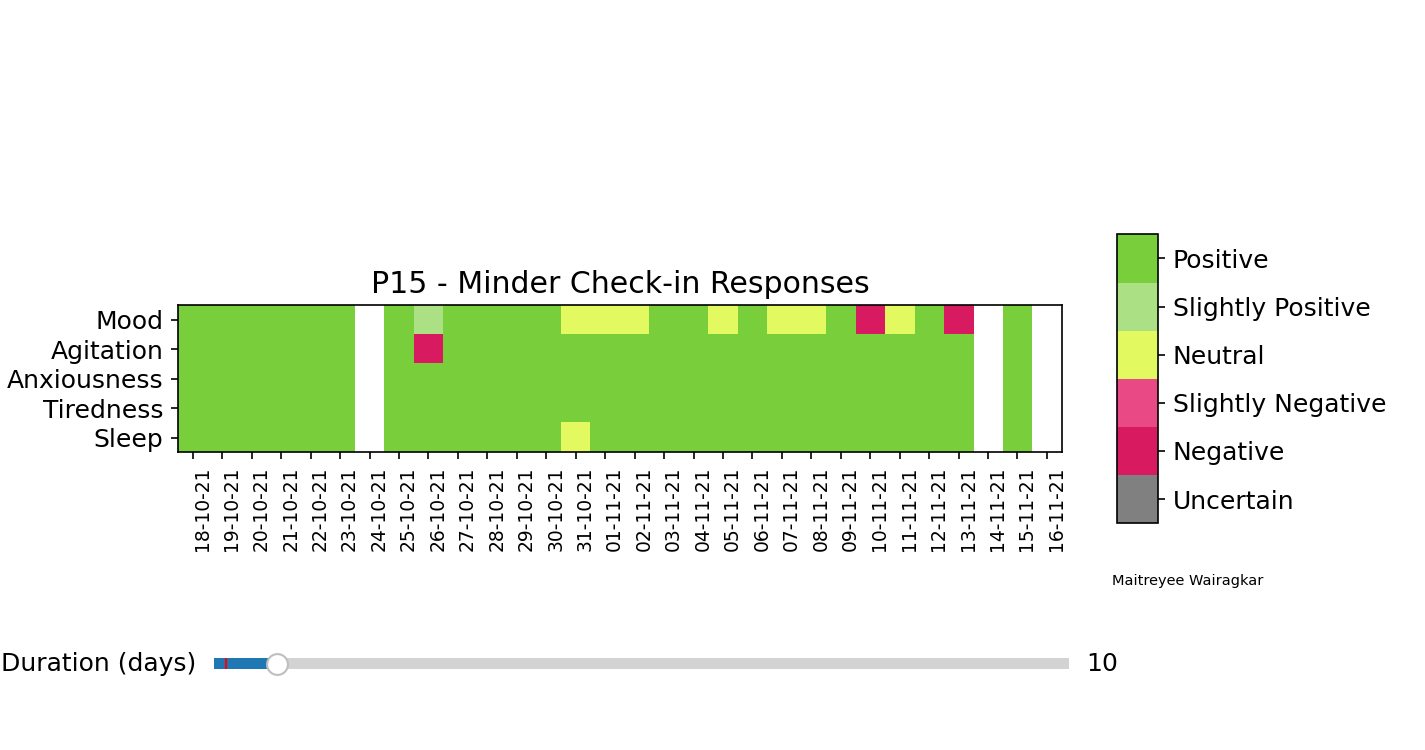

In [17]:
# Define indices for the dataframe
idx = ['Mood', 'Agitation', 'Anxiousness','Tiredness','Sleep']
  
# Define columns for the dataframe (index of the above data frame)
cols = dat_to_plot.index
  
# Enter values in the index and columns and converting them into a pandas dataframe
c = [dat_to_plot['launch'], dat_to_plot['agitation'], dat_to_plot['anxious'],dat_to_plot['tired'], dat_to_plot['sleepquality']]

d = pd.DataFrame(c, columns = cols, index = idx)

#print(d)

# plot heatmap
%matplotlib notebook
fig = plot_heatmap(dat=d, xticks=range(len(cols)), yticks=range(len(idx)), user_id='P15')


In [7]:
# Test preformance of sentiment classification on training data

cnt = 0
predicted_class = []
print('Wrong predictions on training data:')
for test_doc in training_set:
    trainingclassprobability = test_mnw_naive_bayes(test_doc, logprior, loglikelihood, class_list, V)
    
    temp = [x for x, y in trainingclassprobability.items() if y == max(trainingclassprobability.values())] 
    predicted_class.append(temp[0])
    #print([test_doc, ' true class: ', class_labels[cnt],' Predicted class: ',predicted_class[cnt] , ' ', trainingclassprobability])
    cnt +=1

labels = {2:'Positive', 1:'Slightly Positive', 0:'Neutral', -1:'Slightly Negative', -2:'Negative'}
wrong_prediction = 0
for i in range(len(class_labels)):
    if class_labels[i]!=predicted_class[i]:
        wrong_prediction+=1
        print('Data:', [training_set[i]], ', Actual class:', [class_labels[i]], labels[class_labels[i]], ', Predicted class:', [predicted_class[i]], labels[predicted_class[i]])

print(f'Accuracy on training data: {100-(wrong_prediction/len(class_labels))*100:0.2f} %')

# TODO: evaluate performance on test data

Wrong predictions on training data:
Data: ['quite good'] , Actual class: [2] Positive , Predicted class: [1] Slightly Positive
Accuracy on training data: 99.39 %
